# CMP Appendix: Analysis of Unclassified Samples

In [ ]:
NOT_LINUX = False  # set to True, if you have trouble replicating results with your operating system

In [1]:
### UMAP final parameters ###
N_NEIGHBORS = 30
MIN_DIST = 0.01
N_COMPONENTS = 30
RANDOM_STATE = 86531

### HDBSCAN final parameters ###
MIN_SAMPLES = 30
MIN_CLUSTER_SIZE = 10

In [2]:
EMBEDDINGS = 'data/'
SAMPLES = 'noise/samples_student_assistants/'
DATA = 'noise/labeled_data/'

In [3]:
import pandas as pd
import numpy as np
import random
import os

import umap
import hdbscan

import simpledorff
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/home/alina/anaconda3/envs/umap_hdbscan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load strategy texts & embeddings

In [4]:
# load raw strategy sentences
data = pd.read_csv(EMBEDDINGS + 'strategies_raw.csv', sep=';')
strategies = [(data['item'][i], data['strategy text'][i]) for i in range(len(data))]

In [5]:
# load strategy embeddings and convert to numpy array
strategy_embeddings = np.load(EMBEDDINGS + 'strategy_embeddings_masked.npy')

### Define embedding function

In [6]:
def umap_hdbscan(embeds=strategy_embeddings,
                 n_neighbors=N_NEIGHBORS,
                 min_dist=MIN_DIST,
                 n_components=N_COMPONENTS,
                 random_state=RANDOM_STATE,
                 min_cluster_size=MIN_CLUSTER_SIZE,
                 min_samples=MIN_SAMPLES):
    if NOT_LINUX == True:
        umap_embed_fin = np.load(EMBEDDINGS + f'not_linux/umap_embeddings_seed-{RANDOM_STATE}-(final).npy')
    else:
        umap_fin = umap.UMAP(n_neighbors=n_neighbors,
                             min_dist=min_dist,
                             n_components=n_components,
                             metric='cosine',
                             random_state=random_state).fit(embeds)
                             # gives majority of cluster solutions of 1.000 different UMAP seeds

        umap_embed_fin = umap_fin.transform(embeds)

    hdbscan_fin = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                  min_samples=min_samples,
                                  metric='euclidean')

    hdbscan_fin.fit(umap_embed_fin)
    
    return hdbscan_fin

### Compute final UMAP & HDBSCAN combination

In [7]:
hdbscan_fin = umap_hdbscan(embeds=strategy_embeddings)
# cross-check number of clusters (37) & unclustered points (3067)
print(f'Number of clusters: {max(hdbscan_fin.labels_ + 1)}')
print(f'Number of unclustered points: {list(hdbscan_fin.labels_).count(-1)}')

Number of clusters: 37
Number of unclustered points: 3067


In [8]:
strategies_labels = pd.DataFrame([(data['strategy text'][i], hdbscan_fin.labels_[i]) for i in range(len(data))],
                                 columns=['Strategy', 'Label'])
strategies_labels.to_csv(os.path.realpath('.') + '/data/strategies_labels.csv', index=False)

### Sample noise packages for student assistants

In [9]:
# shuffle all noise samples (3,067)
# divide into 3 packages (1,023, 1,022, 1,022)
# draw 205 of each package for cross-labeling (interrater reliability analysis)

noise = [strategies[i] for i in np.where(hdbscan_fin.labels_ == -1)[0]]
random.Random(15).shuffle(noise)  # seed for reproducibility

EM = noise[:1023]
AB = noise[1023:2045]
VP = noise[2045:]

pd.DataFrame(EM, columns=['Item', 'ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_EM.xlsx', index=False)
pd.DataFrame(AB, columns=['Item', 'ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_AB.xlsx', index=False)
pd.DataFrame(VP, columns=['Item', 'ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_VP.xlsx', index=False)

EM_cross = random.Random(15).sample(EM, 205)
AB_cross = random.Random(15).sample(AB, 205)
VP_cross = random.Random(15).sample(VP, 205)

pd.DataFrame(EM_cross, columns=['Item', 'ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_EM-cross.xlsx', index=False)
pd.DataFrame(AB_cross, columns=['Item', 'ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_AB-cross.xlsx', index=False)
pd.DataFrame(VP_cross, columns=['Item', 'ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_VP-cross.xlsx', index=False)

In [10]:
# sample training packages 3x20
# from noise (not from own package and not from package of person who will be cross-labeled)

EM_training = random.Random(15).sample(AB, 20)
EM_training = [s[1] for s in EM_training]
AB_training = random.Random(15).sample(VP, 20)
AB_training = [s[1] for s in AB_training]
VP_training = random.Random(15).sample(EM, 20)
VP_training = [s[1] for s in VP_training]

pd.DataFrame(EM_training, columns=['ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_EM-training.xlsx', index=False)
pd.DataFrame(AB_training, columns=['ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_AB-training.xlsx', index=False)
pd.DataFrame(VP_training, columns=['ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_VP-training.xlsx', index=False)

In [11]:
EM_training_2 = random.Random(16).sample(AB, 50)
pd.DataFrame(EM_training_2, columns=['Item', 'ER-Beschreibung']).to_excel(SAMPLES + 'ER-classification_EM-training-2.xlsx', index=False)

### Define Krippendorff's Alpha function

In [12]:
def krips_alpha(dfs):
    alpha_df = dfs[0]
    for df in (dfs[1], dfs[2]):
        alpha_df = pd.concat([alpha_df, df])
        dups = alpha_df.duplicated(subset=['Item', 'ER Suggestion'], keep=False)
        alpha_df = alpha_df[dups.values]
    
    alpha = simpledorff.calculate_krippendorffs_alpha_for_df(alpha_df,
                                                             experiment_col='ER Suggestion',
                                                             annotator_col='Annotator',
                                                             class_col='Label')
    
    return alpha

### Calculate alpha on three different subsets

In [13]:
# subset AB
AB = pd.read_csv(DATA + 'AB_clean.csv')
AB['Annotator'] = 'AB'
AB = AB[AB['Label'].notna()]
AB = AB.drop_duplicates()

AB_EM = pd.read_csv(DATA + 'AB-cross-EM_clean.csv')
AB_EM['Annotator'] = 'EM'

AB_VP = pd.read_csv(DATA + 'AB-cross-VP_clean.csv')
AB_VP['Annotator'] = 'VP'

krips_alpha([AB, AB_EM, AB_VP])

0.5103610285270468

In [14]:
# subset EM
EM = pd.read_csv(DATA + 'EM_clean.csv')
EM['Annotator'] = 'EM'
EM = EM.drop_duplicates(subset=['Item', 'ER Suggestion'])

EM_AB = pd.read_csv(DATA + 'EM-cross-AB_clean.csv')
EM_AB['Annotator'] = 'AB'

EM_VP = pd.read_csv(DATA + 'EM-cross-VP_clean.csv')
EM_VP['Annotator'] = 'VP'

krips_alpha([EM, EM_AB, EM_VP])

0.4926498729491483

In [15]:
# subset VP
VP = pd.read_csv(DATA + 'VP_clean.csv')
VP['Annotator'] = 'VP'
VP = VP.drop_duplicates(subset=['Item', 'ER Suggestion'])

VP_AB = pd.read_csv(DATA + 'VP-cross-AB_clean.csv')
VP_AB['Annotator'] = 'AB'

VP_EM = pd.read_csv(DATA + 'VP-cross-EM_clean.csv')
VP_EM['Annotator'] = 'EM'

krips_alpha([VP, VP_AB, VP_EM])

0.4516632983274026

### Inspect class distributions

In [16]:
def plot_label_dist(df_labels):
    d = df_labels.value_counts().to_dict()
    d = {k: v for k, v in sorted(d.items(), reverse=True, key=lambda item: item[1])}
    
    fig, ax = plt.subplots(1, 1, figsize=(15,7))
    
    for pos in ('top', 'right', 'bottom', 'left'):
        ax.spines[pos].set_visible(False)
    
    ax.set_facecolor('ghostwhite')
    ax.grid(axis='y', color='lightgrey', linewidth=1)
    ax.set_axisbelow(True)
    ax.set_xlabel('Strategy classes', fontsize=14)
    ax.set_ylabel('Number of instances', fontsize=14)
    ax.bar(d.keys(), d.values(), color='cornflowerblue')
    plt.xticks(rotation=90, fontsize=12)
    
    return fig

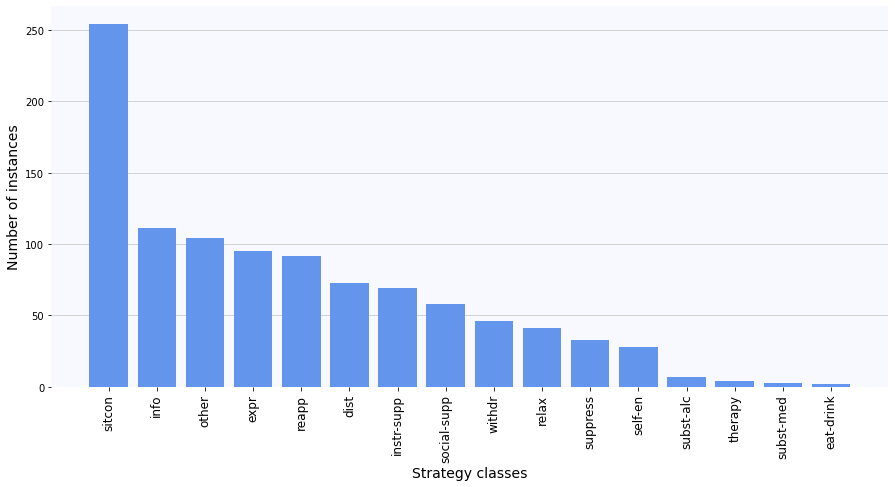

In [17]:
# subset AB
AB = pd.read_csv(DATA + 'AB_clean.csv')
AB_dist = plot_label_dist(AB.Label)

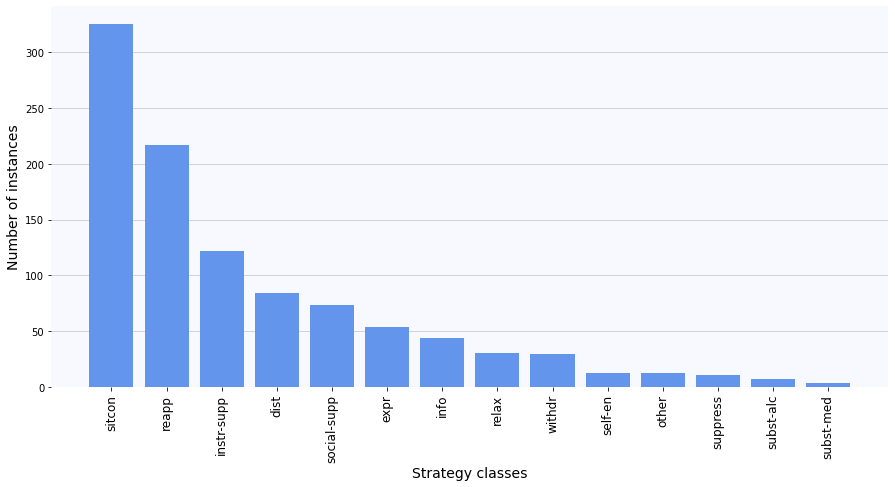

In [18]:
# subset EM
EM = pd.read_csv(DATA + 'EM_clean.csv')
EM_dist = plot_label_dist(EM.Label)

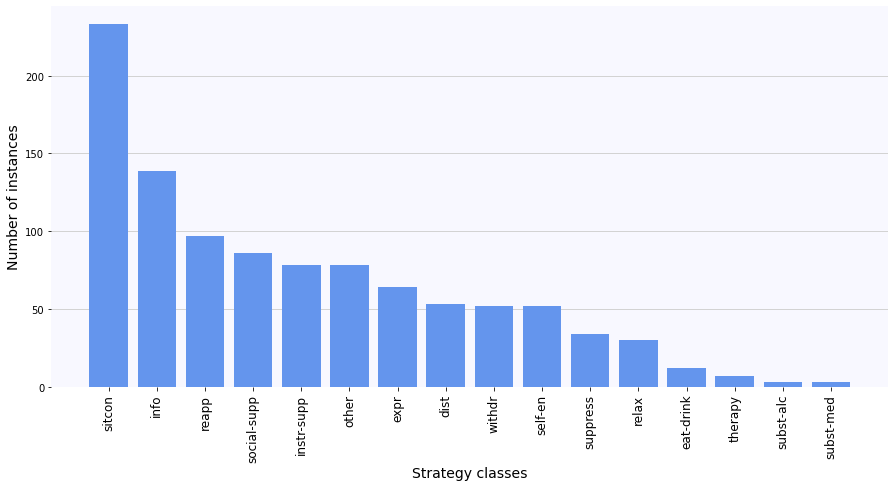

In [19]:
# subset VP
VP = pd.read_csv(DATA + 'VP_clean.csv')
VP_dist = plot_label_dist(VP.Label)

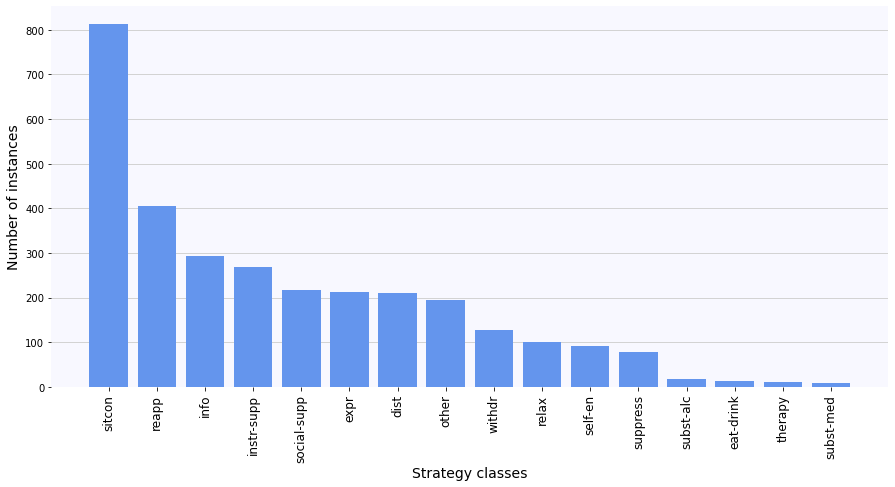

In [20]:
# all non-classified
non_classified = pd.concat([AB, EM, VP])
non_classified_dist = plot_label_dist(non_classified.Label)
plt.savefig('noise/non_classified_dist.svg')

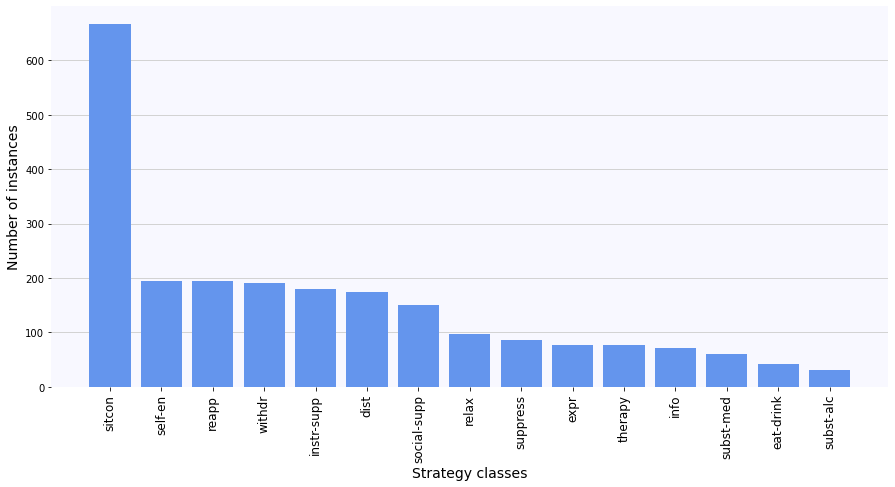

In [21]:
# all classified
classified = pd.read_csv(os.path.realpath('.') + '/data/strategies_labels.csv')
classified = classified[classified.Label != -1]

# np.NaN due to low intrusion task score or based on 'topic words', Cluster 34 not interpretable
labels_classes = {0: np.NaN, 1: 'subst-med', 2: 'sitcon', 3: np.NaN, 4: 'dist',
                  5: 'relax', 6: 'therapy', 7: 'sitcon', 8: np.NaN, 9: 'suppress', 10: np.NaN,
                  11: 'eat-drink', 12: 'subst-alc', 13: np.NaN, 14: 'sitcon', 15: np.NaN,
                  16: 'info', 17: 'withdr', 18: np.NaN, 19: 'sitcon', 20: 'expr',
                  21: 'instr-supp', 22: np.NaN, 23: 'self-en', 24: 'sitcon', 25: 'sitcon',
                  26: 'sitcon', 27: 'social-supp', 28: 'social-supp', 29: 'social-supp', 30: 'sitcon',
                  31: 'expr', 32: np.NaN, 33: 'reapp', 34: np.NaN, 35: 'instr-supp', 36: 'instr-supp'}

classified['Class'] = [labels_classes[x] for x in classified.Label]
classified = classified[classified.Class.notna()]

classified_dist = plot_label_dist(classified.Class)
plt.savefig('noise/classified_dist.svg')

### Percentage of "other" category

In [22]:
def percentage_other(df):
    return len(df[df['Label'] == 'other']) / len(df)

In [23]:
# subset AB
percentage_other(AB)

0.10176125244618395

In [24]:
# subset EM
percentage_other(EM)

0.011730205278592375

In [25]:
# subset VP
percentage_other(VP)

0.07632093933463796

In [26]:
# all non-classified
percentage_other(non_classified)

0.06325399413107272

In [27]:
# percentage "other" over ALL 6,604 strategies
len(non_classified[non_classified['Label'] == 'other'])/ 6064

0.03199208443271768

### New classes in non-classified samples

In [28]:
non_classified['New Label'].value_counts()

accept       76
reflect      73
destr-soc    42
self-depr     3
Name: New Label, dtype: int64

In [29]:
# percentages of new classes in "other"
other = len(non_classified[non_classified.Label == 'other'])
new_classes = non_classified['New Label'].value_counts().to_dict()

for new_class in new_classes.keys():
    print(f"{new_class}: {new_classes[new_class]/other}")

accept: 0.3917525773195876
reflect: 0.37628865979381443
destr-soc: 0.21649484536082475
self-depr: 0.015463917525773196


### Examples for interrater disagreement

In [30]:
AB_drop = AB.drop_duplicates()
df_concat = AB_drop[['Item', 'ER Suggestion', 'Label']].merge(AB_EM[['Item', 'ER Suggestion', 'Label']],
                                                              on=['Item', 'ER Suggestion'], how='inner')
df_concat = df_concat.merge(AB_VP[['Item', 'ER Suggestion', 'Label']],
                            on=['Item', 'ER Suggestion'], how='inner')
df_concat.columns = ['Item', 'ER Suggestion', 'AB', 'EM', 'VP']
df_concat.query('AB != EM != VP')

,Item,ER Suggestion,AB,EM,VP
4,6,Ich distanziere mich von der Bewertung des Kli...,suppress,withdr,reapp
5,2,Ich suche jemanden auf der mir bei meiner Angs...,therapy,instr-supp,therapy
6,5,ich werte die jüngeren Studenten innerlich ab,self-en,reapp,self-en
14,3,Den Verwandten anrufen.,info,social-supp,sitcon
22,4,Reflektieren was der Wahrheit entspricht,other,reapp,other
25,1,"Ich bereite mich darauf vor, ein höheres Arbei...",other,reapp,sitcon
28,1,Früher Feierabend machen und sich einen gemütl...,relax,sitcon,relax
37,7,"Ich schaue nach vorne, kümmere mich erneut um ...",sitcon,reapp,sitcon
41,3,Arzt fragen wie es steht um sie steht,info,instr-supp,info
43,6,Gespräch mit Klient suchen,info,sitcon,info
